In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import pytensor.tensor as pt
from pytensor.tensor.random.utils import params_broadcast_shapes
from sklearn.preprocessing import MaxAbsScaler
from scipy.stats import spearmanr
import xarray as xr

from utils import delayed_adstock
from plots import plot_posterior
from plots import plot_prior_predictive_samples


In [2]:
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.2.0


In [3]:
raw = pd.read_csv('MMM_test_data.csv')
df=raw.copy()


In [4]:
spend_channels= ['spend_channel_1','spend_channel_2','spend_channel_3','spend_channel_4','spend_channel_5','spend_channel_6','spend_channel_7']
df['start_of_week'] = pd.to_datetime(df['start_of_week'],format="%d-%m-%y",dayfirst=True)
date_data= df['start_of_week']
channel_data = df[spend_channels]
target_data=df['revenue']
n_obs,n_channels= np.shape(channel_data)

In [5]:
df['day'] = df.start_of_week.dt.dayofyear
n_order = 7
periods = df["day"] / 365.25
fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)

trend = (df.index - df.index.min()) / (df.index.max() - df.index.min())
df['trend'] = trend
seasonality =  fourier_features



In [6]:
target_scaler = MaxAbsScaler()
target_scaler.fit(target_data.values.reshape(-1,1))
target_scaled = pd.Series(target_scaler.transform(target_data.values.reshape(-1,1)).flatten())

channel_scaler = MaxAbsScaler()
channel_scaler.fit(channel_data)
channel_scaled = pd.DataFrame(channel_scaler.transform(channel_data),columns=channel_data.columns)


<Axes: >

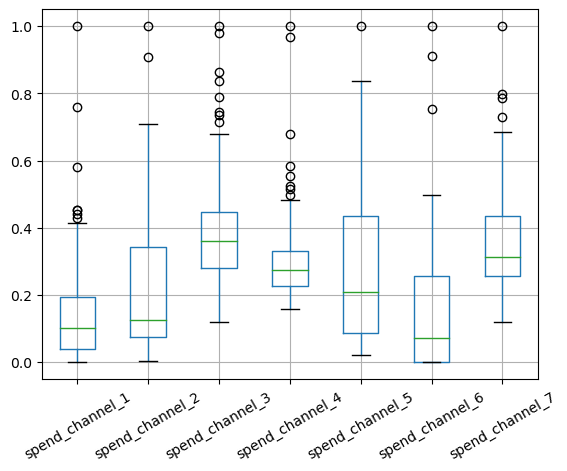

In [7]:
channel_scaled.boxplot( rot=30)

In [8]:
coords={"date": date_data,
        "channel": channel_scaled,
        "seasonality":seasonality,
        "trend":df['trend']}

In [59]:
max_lag=13

with pm.Model(coords=coords) as model:
    #data containers
    channel_data_ = pm.MutableData(
        name="channel_data",
        value=channel_scaled,
        dims=("date", "channel"),
    )
    seasonality_ = pm.MutableData(
        name="seasonality_data", value=seasonality, dims=("date", "seasonality")
    )
    trend_ = pm.MutableData(
        name="t", value=df['trend'], dims=("date")
    )
    
    target_ = pm.MutableData(name="target", value=target_scaled, dims="date")

    #-priors
    intercept = pm.Normal(name="intercept", mu=0, sigma=1)
    b_trend = pm.Normal(name="b_trend", mu=0, sigma=1)
    beta_channel = pm.HalfNormal(
        name="beta_channel", sigma=1, dims="channel"
    )
    alpha = pm.Beta(name="alpha", alpha=3, beta=3, dims="channel")
    theta = pm.Uniform('delay',lower=0,upper=max_lag-1,dims='channel')
    sigma = pm.HalfNormal(name="sigma", sigma=1)
    fourier_control = pm.Laplace(
        name="gamma_control", mu=0, b=1, dims="seasonality"
    )
    # degrees of freedom of the t distribution
    nu = pm.Gamma(name="nu", alpha=15, beta=1)
    
    #model parametrization
    channel_adstock = pm.Deterministic(
        name="channel_adstock",
        var=delayed_adstock(
            x=channel_data_,
            alpha=alpha,
            theta=theta,
            l_max = max_lag-1
        ),
        dims=("date", "channel"),
    )

    channel_contributions = pm.Deterministic(
        name="channel_contributions",
        var=channel_adstock*beta_channel,
        dims=("date", "channel"),
    )
    
    mu_var =  channel_contributions.sum(axis=-1)
    
    trend = pm.Deterministic("trend", intercept + b_trend * trend_, dims="date")
    
    control_contributions = pm.Deterministic(
        name="control_contributions",
        var=seasonality_ * fourier_control,
        dims=("date", "seasonality"),
    )
    
    mu_var += control_contributions.sum(axis=-1)
    mu_var += trend
    mu = pm.Deterministic(name="mu", var=mu_var, dims="date")

    pm.StudentT(
        name="likelihood",
        nu=nu,
        mu=mu,
        sigma=sigma,
        observed=target_,
        dims="date",
    )
    model_prior_predictive = pm.sample_prior_predictive()

Sampling: [alpha, b_trend, beta_channel, delay, gamma_control, intercept, likelihood, nu, sigma]


In [60]:
model

            intercept ~ N(0, 1)
              b_trend ~ N(0, 1)
         beta_channel ~ N**+(0, 1)
                alpha ~ Beta(3, 3)
                delay ~ U(0, 12)
                sigma ~ N**+(0, 1)
        gamma_control ~ Laplace(0, 1)
                   nu ~ Gamma(15, f())
      channel_adstock ~ Deterministic(f(alpha, delay))
channel_contributions ~ Deterministic(f(beta_channel, alpha, delay))
                trend ~ Deterministic(f(intercept, b_trend))
control_contributions ~ Deterministic(f(gamma_control))
                   mu ~ Deterministic(f(intercept, b_trend, gamma_control, beta_channel, alpha, delay))
           likelihood ~ StudentT(nu, mu, sigma)

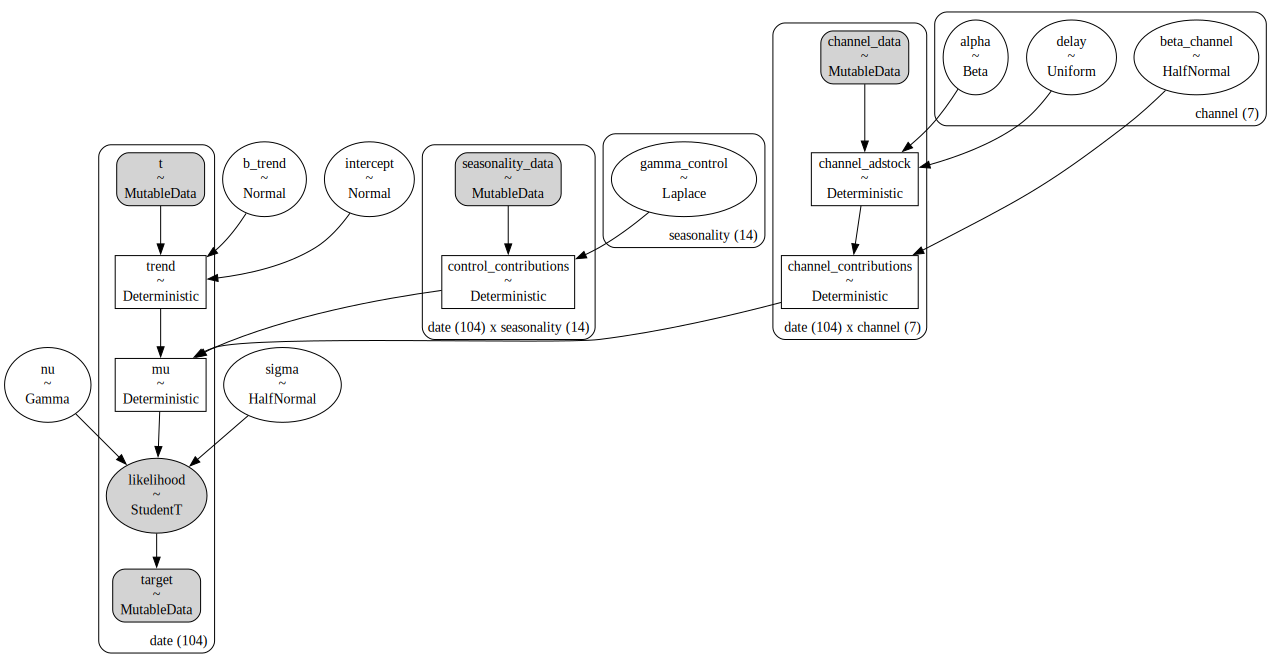

In [10]:
pm.model_to_graphviz(model=model)

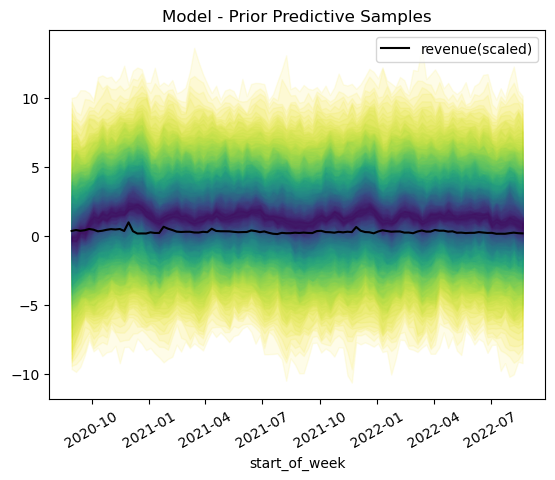

In [61]:
# useful way to color the distribution
plot_settings={
'palette' :"viridis_r",
'cmap' :plt.get_cmap("viridis_r"),
'percs' :np.linspace(51, 99, 100),
'colors' :(np.linspace(51, 99, 100) - np.min(np.linspace(51, 99, 100))) / (np.max(np.linspace(51, 99, 100)) - np.min(np.linspace(51, 99, 100)))}
plot_prior_predictive_samples(model_prior_predictive,target_scaled,date_data,plot_settings)


In [62]:
with model:
    model_trace = pm.sample(
        nuts_sampler="numpyro",
        draws=8_000,
        chains=4,
        idata_kwargs={"log_likelihood": True},
    )
    model_posterior_predictive = pm.sample_posterior_predictive(
        trace=model_trace
    )

/home/shamecube/miniconda3/envs/bayes/lib/python3.9/site-packages/pymc/sampling/mcmc.py:243: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:05.581217
Sampling...


Compiling.. :   0%|                                             | 0/9000 [00:00<?, ?it/s]

  0%|                                                           | 0/9000 [00:00<?, ?it/s]

Compiling.. :   0%|                                             | 0/9000 [00:00<?, ?it/s]


  0%|                                                           | 0/9000 [00:00<?, ?it/s]


Compiling.. :   0%|                                             | 0/9000 [00:00<?, ?it/s]

Running chain 2:   0%|                                          | 0/9000 [00:05<?, ?it/s]


Running chain 0:   5%|█▌                              | 450/9000 [00:10<01:33, 91.45it/s]

Running chain 2:   5%|█▌                              | 450/9000 [00:10<01:34, 90.82it/s]


Running chain 0:  10%|███                            | 900/9000 [00:11<00:51, 155.82it/s]

Running chain 2:  10%|███                            | 900/9000 [00:11<00:54, 148.66it/s]


Running chain 0:  15%|████▌                         | 1350/9000 [00:13<00:41, 183.45i

Sampling time =  0:00:56.665401
Transforming variables...
Transformation time =  0:00:02.013351
Computing Log Likelihood...
Log Likelihood time =  0:00:02.754977


Sampling: [likelihood]


In [63]:
az.summary(
    data=model_trace,
    var_names=['alpha','delay','intercept','b_trend','beta_channel','sigma'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
alpha[spend_channel_1]         0.474  0.192   0.120    0.815      0.001   
alpha[spend_channel_2]         0.598  0.188   0.248    0.917      0.001   
alpha[spend_channel_3]         0.445  0.172   0.123    0.755      0.001   
alpha[spend_channel_4]         0.514  0.190   0.174    0.863      0.001   
alpha[spend_channel_5]         0.498  0.187   0.158    0.838      0.001   
alpha[spend_channel_6]         0.555  0.173   0.225    0.852      0.001   
alpha[spend_channel_7]         0.498  0.181   0.165    0.830      0.001   
delay[spend_channel_1]         6.421  2.607   1.242   10.902      0.034   
delay[spend_channel_2]         3.618  2.262   0.000    8.236      0.029   
delay[spend_channel_3]         0.317  0.669   0.000    0.581      0.020   
delay[spend_channel_4]         4.831  3.275   0.000   10.310      0.030   
delay[spend_channel_5]         4.547  3.700   0.000   11.013      0.032   
delay[spend_channel_6]         1.337  0.696   0.106    2.215      0.008   
delay[spend_channel_7]         3.193  1.024   0.428    4.462      0.026   
intercept                      0.010  0.074  -0.129    0.155      0.001   
b_trend                       -0.185  0.079  -0.334   -0.036      0.001   
beta_channel[spend_channel_1]  0.116  0.085   0.000    0.269      0.001   
beta_channel[spend_channel_2]  0.225  0.104   0.031    0.417      0.001   
beta_channel[spend_channel_3]  0.376  0.119   0.150    0.603      0.002   
beta_channel[spend_channel_4]  0.087  0.074   0.000    0.222      0.001   
beta_channel[spend_channel_5]  0.041  0.045   0.000    0.125      0.000   
beta_channel[spend_channel_6]  0.305  0.093   0.128    0.483      0.001   
beta_channel[spend_channel_7]  0.320  0.114   0.103    0.536      0.001   
sigma                          0.057  0.007   0.044    0.071      0.000   

                               mcse_sd  ess_bulk  ess_tail  r_hat  
alpha[spend_channel_1]           0.001   23089.0   20459.0    1.0  
alpha[spend_channel_2]           0.001   22587.0   21455.0    1.0  
alpha[spend_channel_3]           0.001   16646.0   13409.0    1.0  
alpha[spend_channel_4]           0.001   29946.0   21853.0    1.0  
alpha[spend_channel_5]           0.001   34713.0   22546.0    1.0  
alpha[spend_channel_6]           0.001   21845.0   21075.0    1.0  
alpha[spend_channel_7]           0.001   19665.0   17957.0    1.0  
delay[spend_channel_1]           0.024    8361.0   12683.0    1.0  
delay[spend_channel_2]           0.021    6585.0    9841.0    1.0  
delay[spend_channel_3]           0.014    5034.0    1844.0    1.0  
delay[spend_channel_4]           0.021   12076.0   16856.0    1.0  
delay[spend_channel_5]           0.023   15206.0   19977.0    1.0  
delay[spend_channel_6]           0.008   11334.0    9772.0    1.0  
delay[spend_channel_7]           0.018    2757.0    1065.0    1.0  
intercept                        0.001    3087.0    3290.0    1.0  
b_trend                          0.001    8235.0   13876.0    1.0  
beta_channel[spend_channel_1]    0.001    8031.0   12999.0    1.0  
beta_channel[spend_channel_2]    0.001    8079.0    9068.0    1.0  
beta_channel[spend_channel_3]    0.002    3027.0    2172.0    1.0  
beta_channel[spend_channel_4]    0.000   12270.0   15660.0    1.0  
beta_channel[spend_channel_5]    0.000   11052.0   13820.0    1.0  
beta_channel[spend_channel_6]    0.001    4448.0    3688.0    1.0  
beta_channel[spend_channel_7]    0.001    6976.0    6197.0    1.0  
sigma                            0.000   12909.0   20438.0    1.0

/home/shamecube/miniconda3/envs/bayes/lib/python3.9/site-packages/arviz/plots/traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (126), generating only 20 plots
  warnings.warn(


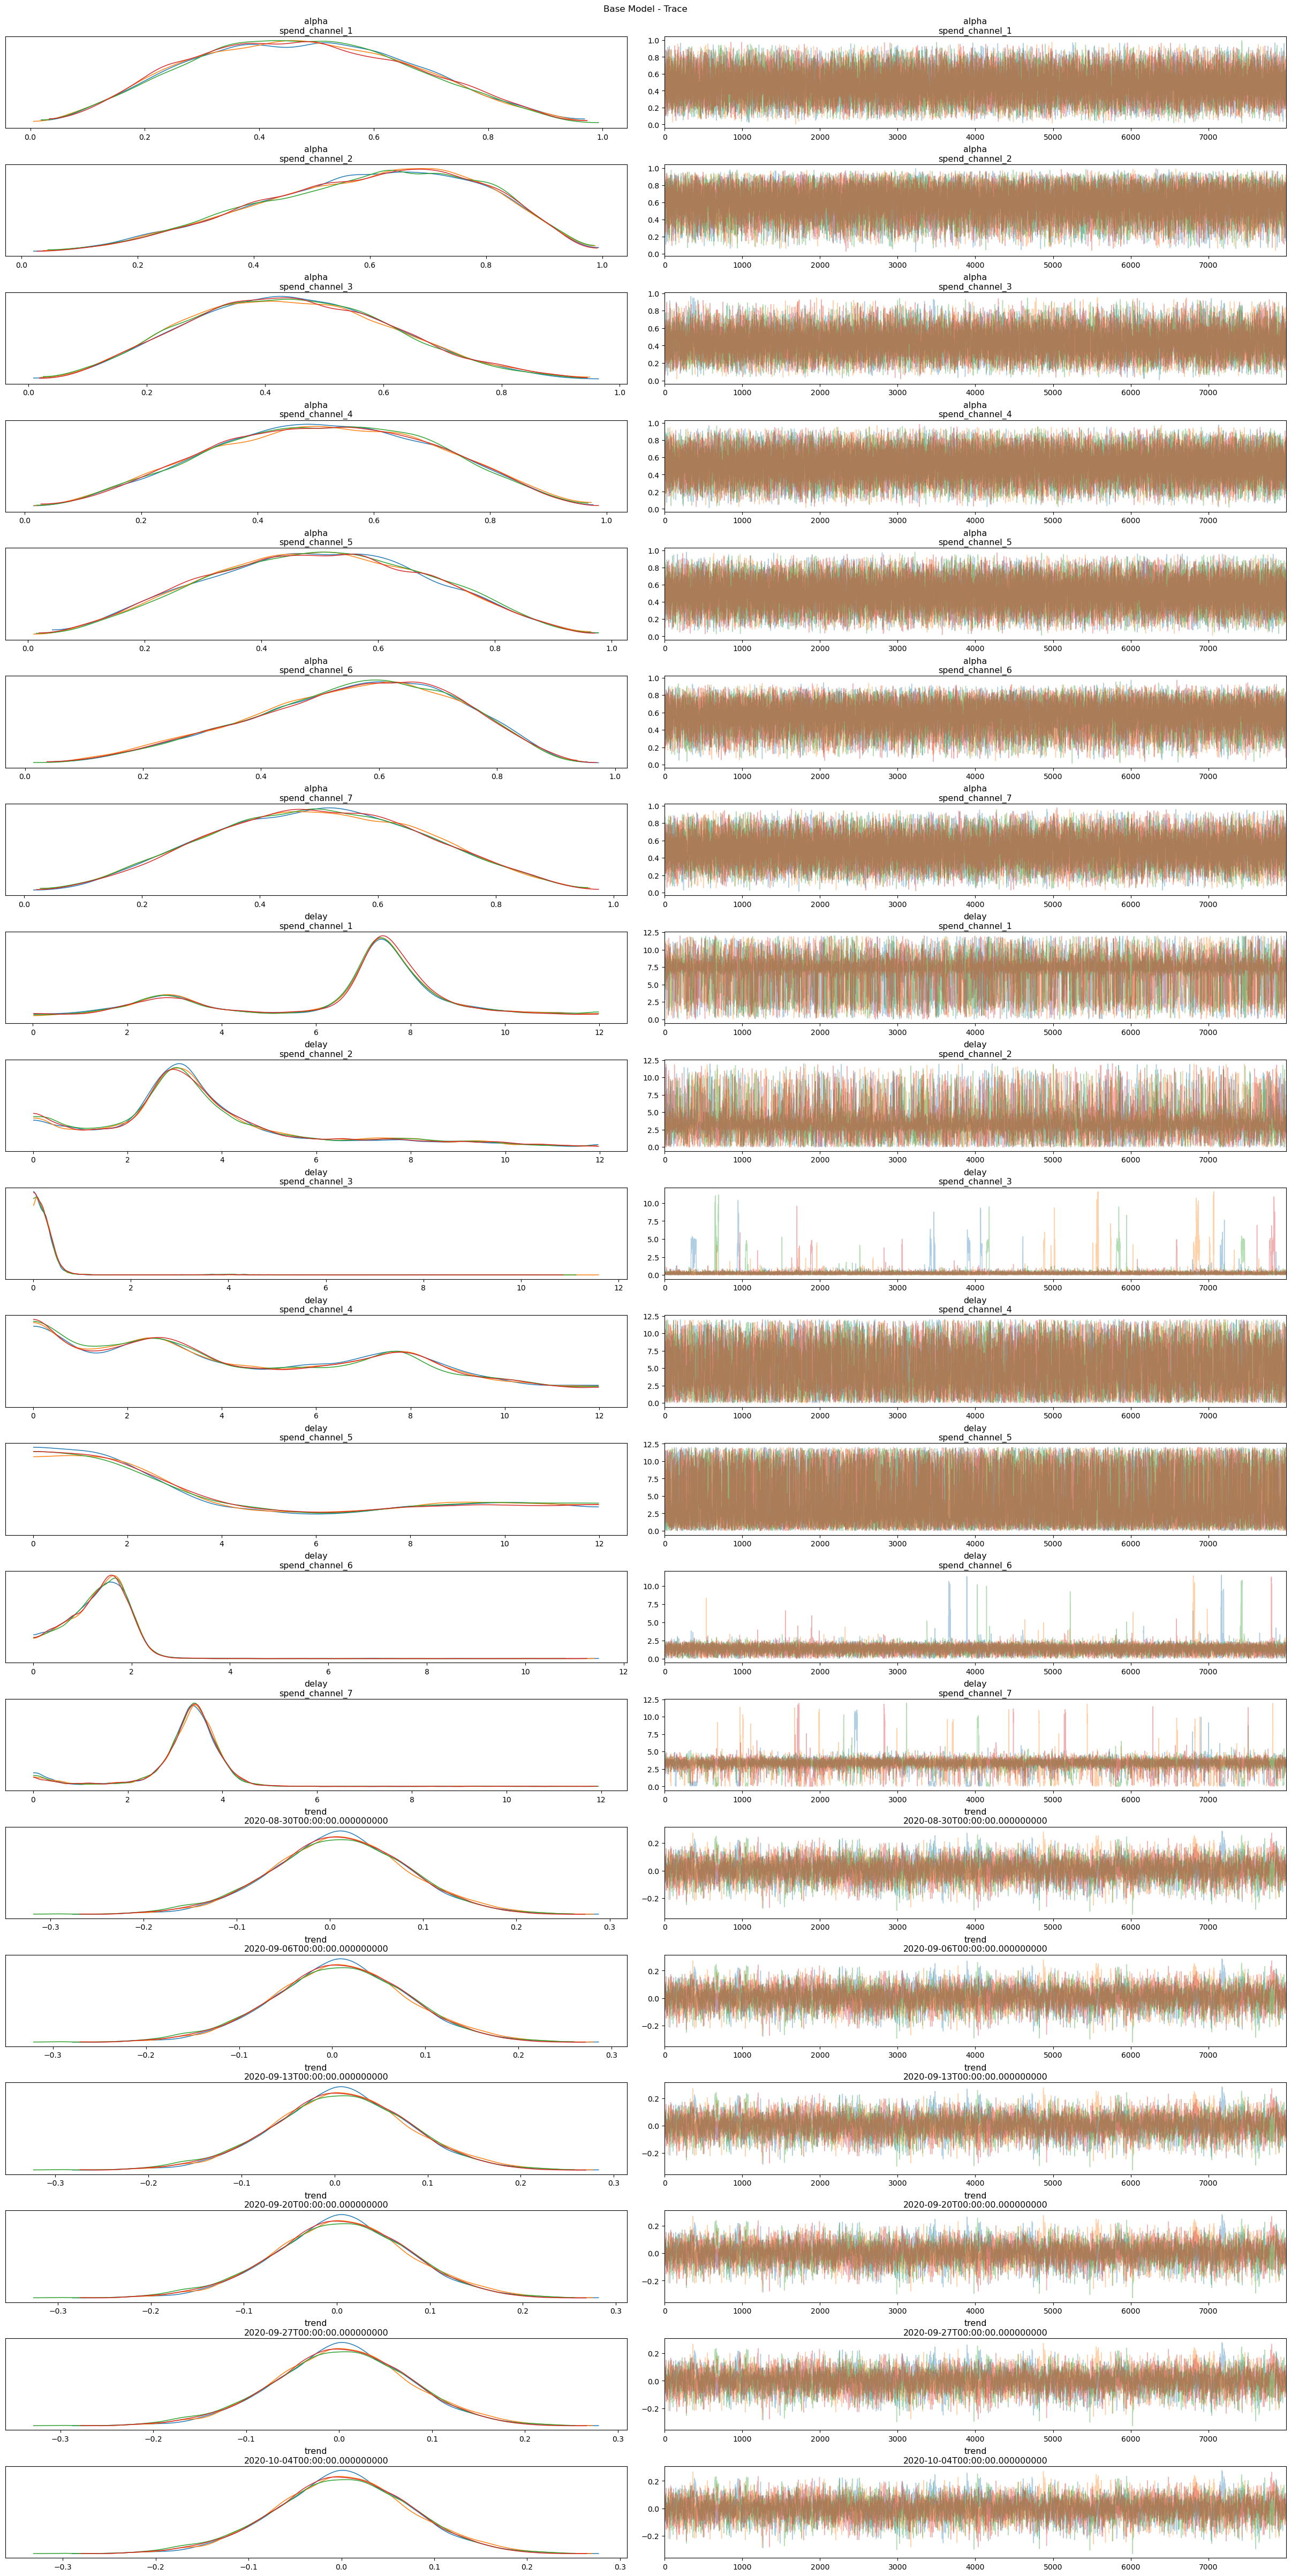

In [64]:
axes = az.plot_trace(
    data=model_trace,
#     var_names=['alpha','delay','intercept','b_trend','beta_channel','nu','gamma_control'],
    var_names=['alpha','delay','trend','beta_channel','sigma'],
    compact=False,
    combined=False,
    backend_kwargs={
        "figsize": (24, 48),
        "layout": "constrained"
    },
)
fig = axes[0][0].get_figure()
fig.suptitle("Base Model - Trace")
plt.show()

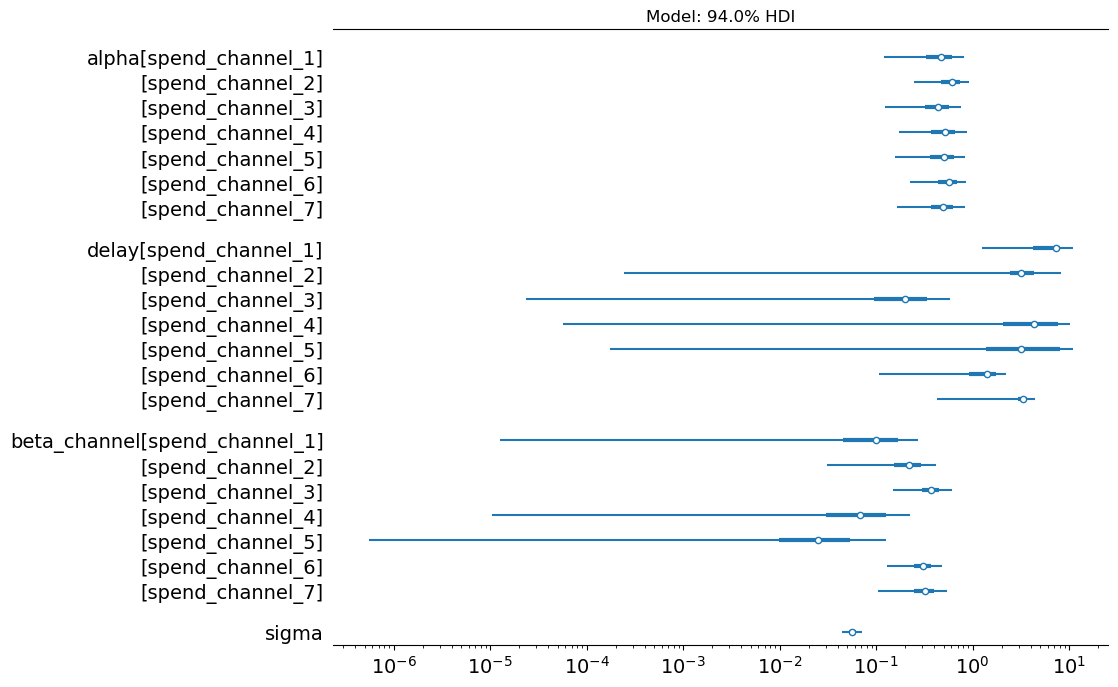

In [65]:
fig, ax = plt.subplots(figsize=(10, 8))
az.plot_forest(
    data=model_trace,
    var_names=['alpha','delay','beta_channel','sigma'],
    combined=True,
    ax=ax
)
ax.set(
    title="Model: 94.0% HDI",
    xscale="log"
)
plt.show()

In [ ]:
## posterior prediction

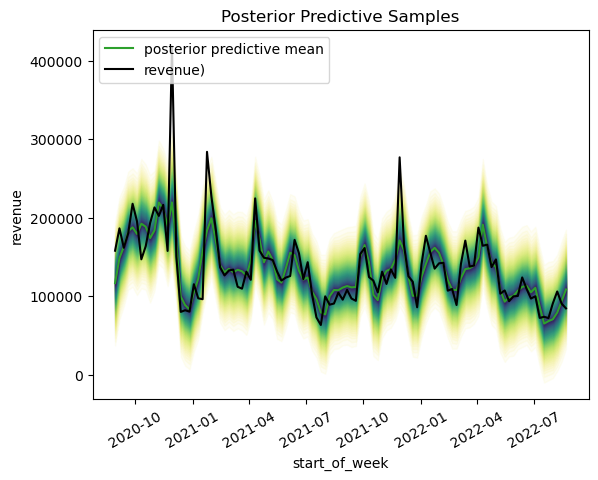

In [66]:
plot_posterior(model_posterior_predictive,date_data,target_data,target_scaler,plot_settings)


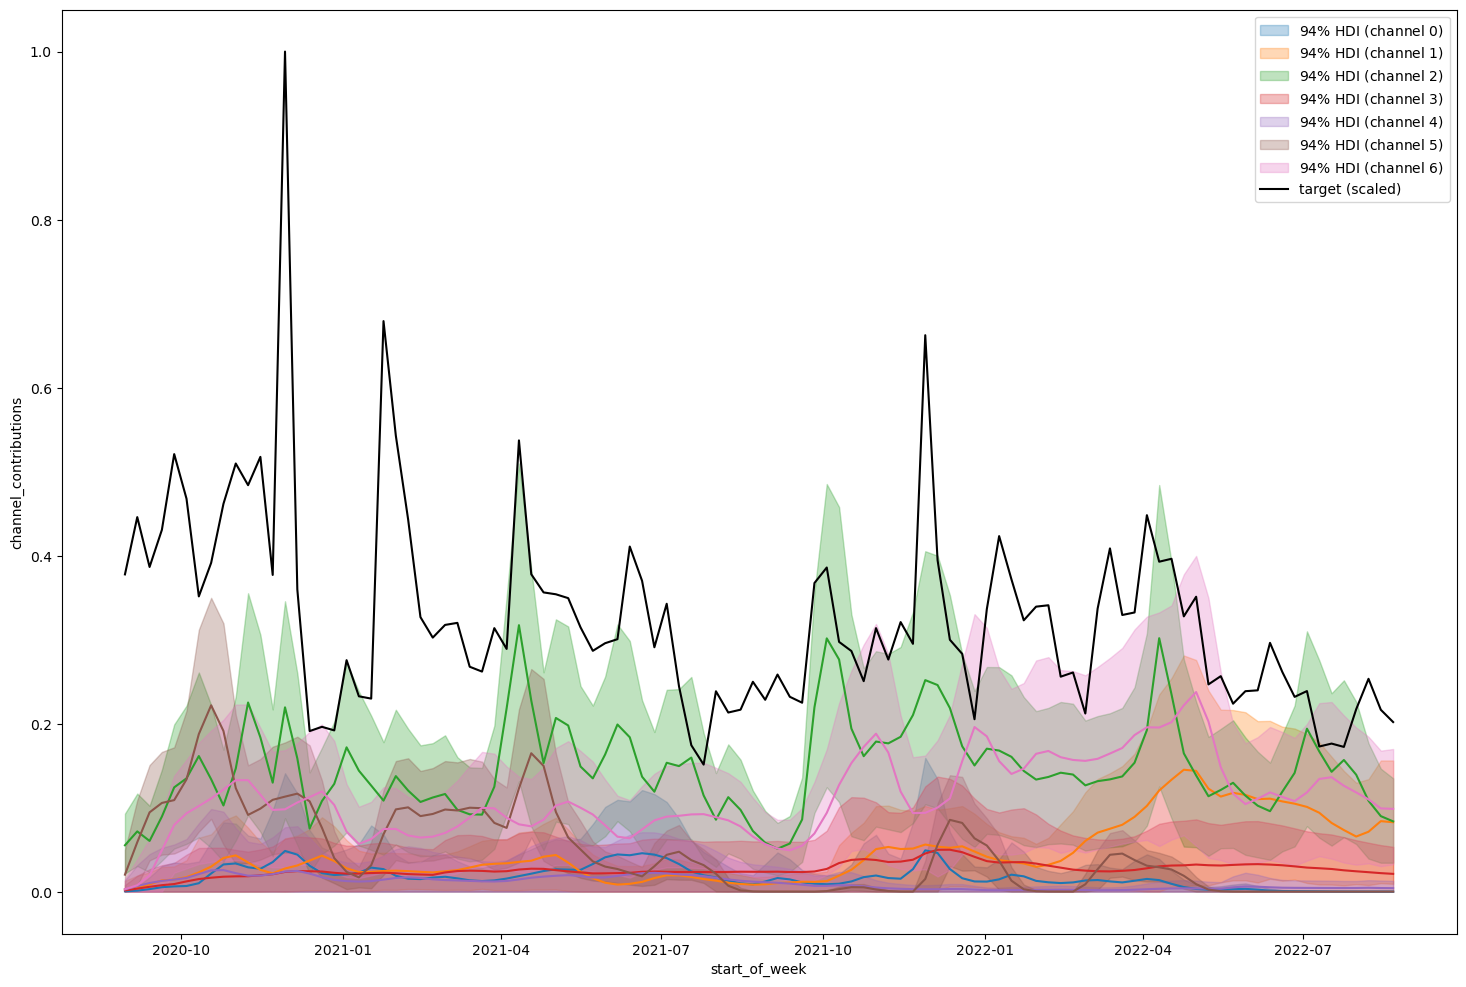

In [69]:
#The HDI can be used in the context of
#uncertainty characterisation of posterior distributions as Credible Interval (CI).
model_hdi = az.hdi(ary=model_trace)

fig, ax = plt.subplots(figsize=(18, 12))

for i in range(n_channels):
    ax.fill_between(
        x=date_data,
        y1=model_hdi['channel_contributions'][:, i,0],
        y2=model_hdi['channel_contributions'][:, i,1],
        color=f"C{i}",
        alpha=0.3,
        label=f"$94\%$ HDI (channel {i})",
    )
    sns.lineplot(
        x=date_data,
        y=model_trace.posterior['channel_contributions'].stack(sample=("chain", "draw")).mean(axis=2)[:,i]
    )
sns.lineplot(x=date_data, y=target_scaled, color="black", alpha=1.0, label="target (scaled)", ax=ax)
plt.show()

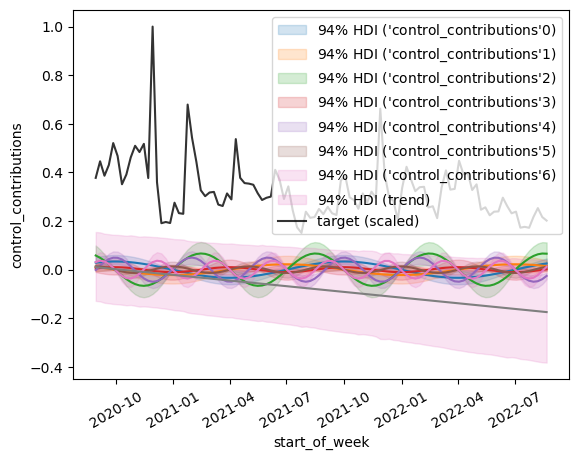

In [78]:
# compute HDI for all the control parameters
fig, ax = plt.subplots()

for i in range(n_channels):
    ax.fill_between(
        x=date_data,
        y1=model_hdi['control_contributions'][:, i,0],
        y2=model_hdi['control_contributions'][:, i,1],
        color=f"C{i}",
        alpha=0.2,
        label=f"$94\%$ HDI ('control_contributions'{i})",
    )
    sns.lineplot(
        x=date_data,
        y=model_trace.posterior['control_contributions'].stack(sample=("chain", "draw")).mean(axis=2)[:,i]
    )

ax.fill_between(
    x=date_data,
    y1=model_hdi['trend'][:,0],
    y2=model_hdi['trend'][:,1],
    color=f"C{i}",
    alpha=0.2,
    label=f"$94\%$ HDI ({'trend'})",
)
sns.lineplot(
    x=date_data,
    y=model_trace.posterior['trend'].stack(sample=("chain", "draw")).mean(axis=1)
)
sns.lineplot(x=date_data, y=target_scaled, color="black", alpha=0.8, label="target (scaled)", ax=ax)
plt.xticks(rotation=30)
plt.show()

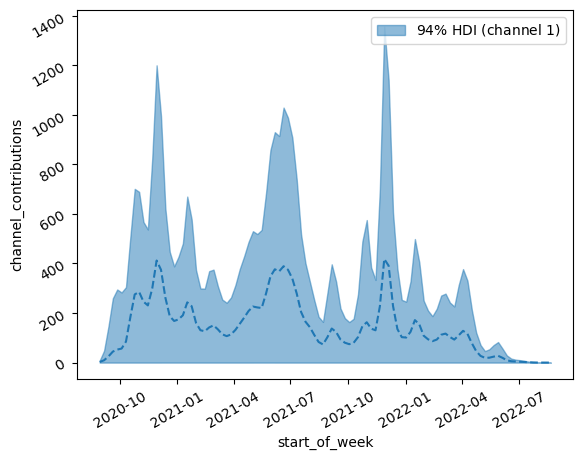

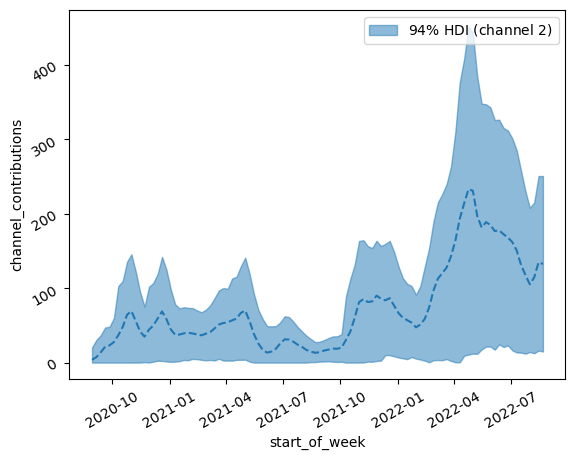

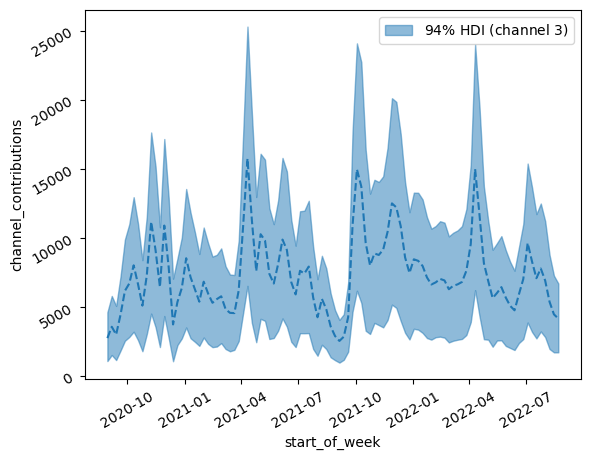

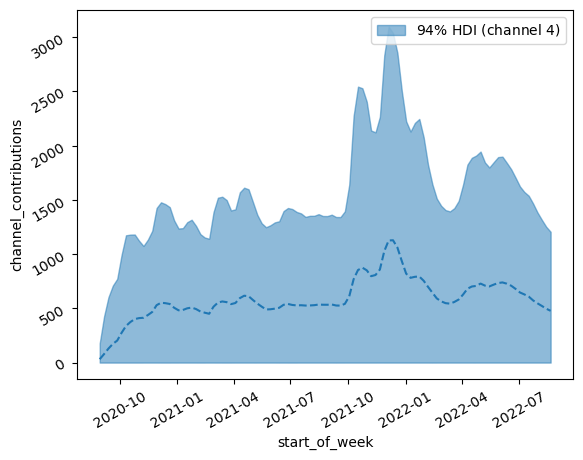

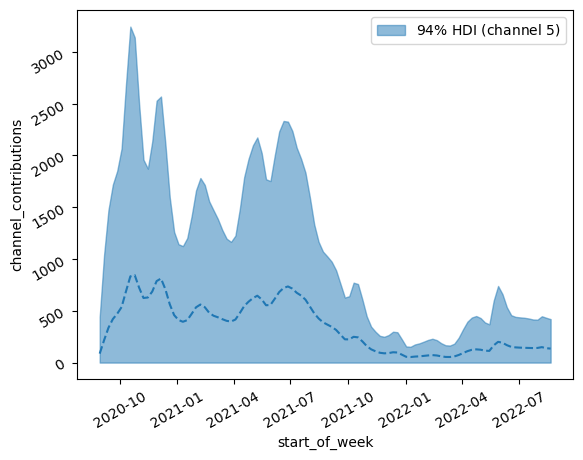

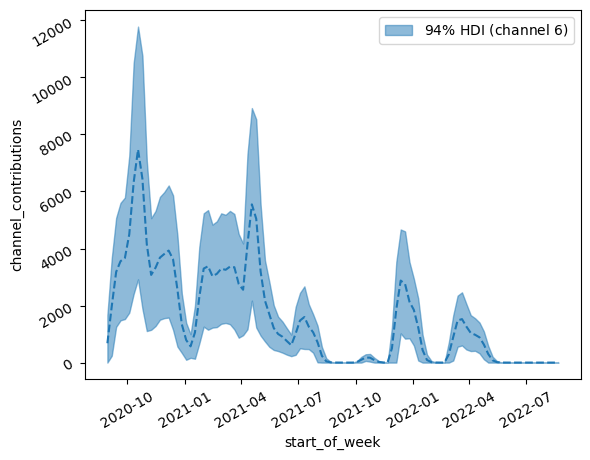

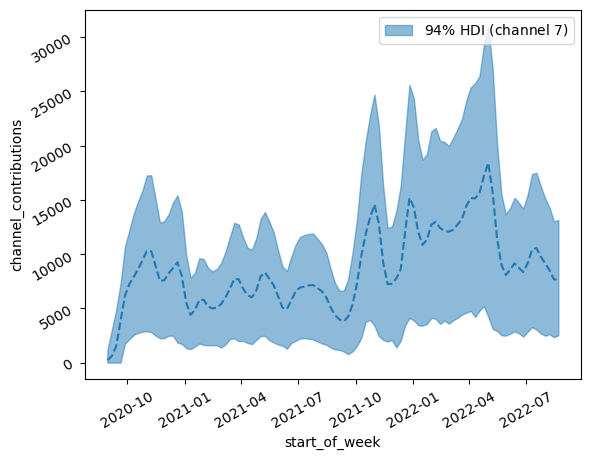

In [84]:
#channel contribtuion figures

channel_contributions_posterior_samples = xr.apply_ufunc(
    lambda x: channel_scaler.inverse_transform(X=x),
    model_trace.posterior["channel_contributions"],
    input_core_dims=[["date","channel"]],
    output_core_dims=[["date","channel"]],
    vectorize=True,
)


channel_effect_hdi = az.hdi(ary=channel_contributions_posterior_samples)["channel_contributions"]

for i in range(n_channels):

    fig, ax = plt.subplots()
    ax.fill_between(
        x=date_data,
        y1=channel_effect_hdi[:,i ,0],
        y2=channel_effect_hdi[:,i ,1],
        color="C0",
        alpha=0.5,
        label=f"$94\%$ HDI (channel {i+1})",
    )
    ax.tick_params(labelrotation=30)
    sns.lineplot(
        x=date_data,
        y=channel_contributions_posterior_samples.stack(sample=("chain", "draw")).mean(axis=2)[:,i],
        linestyle="--",
    )
ax.legend(loc="upper right")
plt.show()

In [72]:
# 2nd model with normal likelihood
max_lag=13

with pm.Model(coords=coords) as model_normal:
    #data containers
    channel_data_ = pm.MutableData(
        name="channel_data",
        value=channel_scaled,
        dims=("date", "channel"),
    )
    seasonality_ = pm.MutableData(
        name="seasonality_data", value=seasonality, dims=("date", "seasonality")
    )
    trend_ = pm.MutableData(
        name="t", value=df['trend'], dims=("date")
    )
    
    target_ = pm.MutableData(name="target", value=target_scaled, dims="date")

    #-priors
    intercept = pm.Normal(name="intercept", mu=0, sigma=1)
    b_trend = pm.Normal(name="b_trend", mu=0, sigma=1)
    beta_channel = pm.HalfNormal(
        name="beta_channel", sigma=1, dims="channel"
    )
    alpha = pm.Beta(name="alpha", alpha=3, beta=3, dims="channel")
    theta = pm.Uniform('delay',lower=0,upper=max_lag,dims='channel')
    sigma = pm.HalfNormal(name="sigma", sigma=1)
    fourier_control = pm.Laplace(
        name="gamma_control", mu=0, b=1, dims="seasonality"
    )
    #model parametrization
    channel_adstock = pm.Deterministic(
        name="channel_adstock",
        var=delayed_adstock(
            x=channel_data_,
            alpha=alpha,
            theta=theta,
            l_max = max_lag-1
        ),
        dims=("date", "channel"),
    )

    channel_contributions = pm.Deterministic(
        name="channel_contributions",
        var=channel_adstock*beta_channel,
        dims=("date", "channel"),
    )
    
    mu_var =  channel_contributions.sum(axis=-1)
    
    trend = pm.Deterministic("trend", intercept + b_trend * trend_, dims="date")
    
    control_contributions = pm.Deterministic(
        name="control_contributions",
        var=seasonality_ * fourier_control,
        dims=("date", "seasonality"),
    )
    
    mu_var += control_contributions.sum(axis=-1)
    mu_var += trend
    mu = pm.Deterministic(name="mu", var=mu_var, dims="date")

    pm.Normal(
                name="likelihood",
                mu=mu,
                sigma=sigma,
                observed=target_,
                dims="date",
            )
    model_prior_predictive_normal = pm.sample_prior_predictive()

Sampling: [alpha, b_trend, beta_channel, delay, gamma_control, intercept, likelihood, sigma]


In [73]:
model_normal

            intercept ~ N(0, 1)
              b_trend ~ N(0, 1)
         beta_channel ~ N**+(0, 1)
                alpha ~ Beta(3, 3)
                delay ~ U(0, 13)
                sigma ~ N**+(0, 1)
        gamma_control ~ Laplace(0, 1)
      channel_adstock ~ Deterministic(f(alpha, delay))
channel_contributions ~ Deterministic(f(beta_channel, alpha, delay))
                trend ~ Deterministic(f(intercept, b_trend))
control_contributions ~ Deterministic(f(gamma_control))
                   mu ~ Deterministic(f(intercept, b_trend, gamma_control, beta_channel, alpha, delay))
           likelihood ~ N(mu, sigma)

In [46]:
with model_normal:
    model_trace_normal = pm.sample(
        nuts_sampler="numpyro",
        draws=8_000,
        chains=4,
        idata_kwargs={"log_likelihood": True},
    )
    model_posterior_predictive_normal = pm.sample_posterior_predictive(
        trace=model_trace_normal
    )

/home/shamecube/miniconda3/envs/bayes/lib/python3.9/site-packages/pymc/sampling/mcmc.py:243: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:04.785763
Sampling...


Compiling.. :   0%|                                             | 0/9000 [00:00<?, ?it/s]

  0%|                                                           | 0/9000 [00:00<?, ?it/s]

Compiling.. :   0%|                                             | 0/9000 [00:00<?, ?it/s]


  0%|                                                           | 0/9000 [00:00<?, ?it/s]


Running chain 0:   0%|                                          | 0/9000 [00:04<?, ?it/s]


Running chain 3:   0%|                                          | 0/9000 [00:04<?, ?it/s]

Running chain 1:   0%|                                          | 0/9000 [00:04<?, ?it/s]

Running chain 0:   5%|█▌                              | 450/9000 [00:09<01:32, 92.33it/s]


Running chain 1:  10%|███                            | 900/9000 [00:11<00:52, 154.17it/s]

Running chain 2:  10%|███                            | 900/9000 [00:11<00:54, 147.37it/s]


Running chain 1:  15%|████▌                         | 1350/9000 [00:13<00:39, 191.32i

Sampling time =  0:01:07.393249
Transforming variables...
Transformation time =  0:00:01.763682
Computing Log Likelihood...


Sampling: [likelihood]


Log Likelihood time =  0:00:02.118567


In [74]:
dataset_dict = {
    "model": model_trace,
    "model_normal": model_trace_normal,
}
df_comp = az.compare(compare_dict=dataset_dict, ic="loo", method="stacking", scale="log")
df_comp

/home/shamecube/miniconda3/envs/bayes/lib/python3.9/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/shamecube/miniconda3/envs/bayes/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


rank    elpd_loo      p_loo  elpd_diff   weight         se  \
model            0  112.627674  31.981810   0.000000  0.95052  14.769714   
model_normal     1   97.191431  33.070613  15.436244  0.04948  15.930131   

                   dse  warning scale  
model         0.000000    False   log  
model_normal  5.585915     True   log

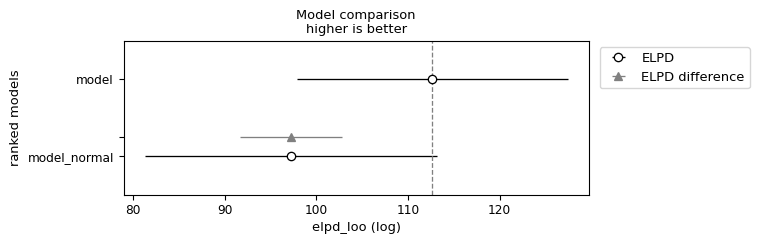

In [75]:
az.plot_compare(df_comp, insample_dev=False)
plt.show()

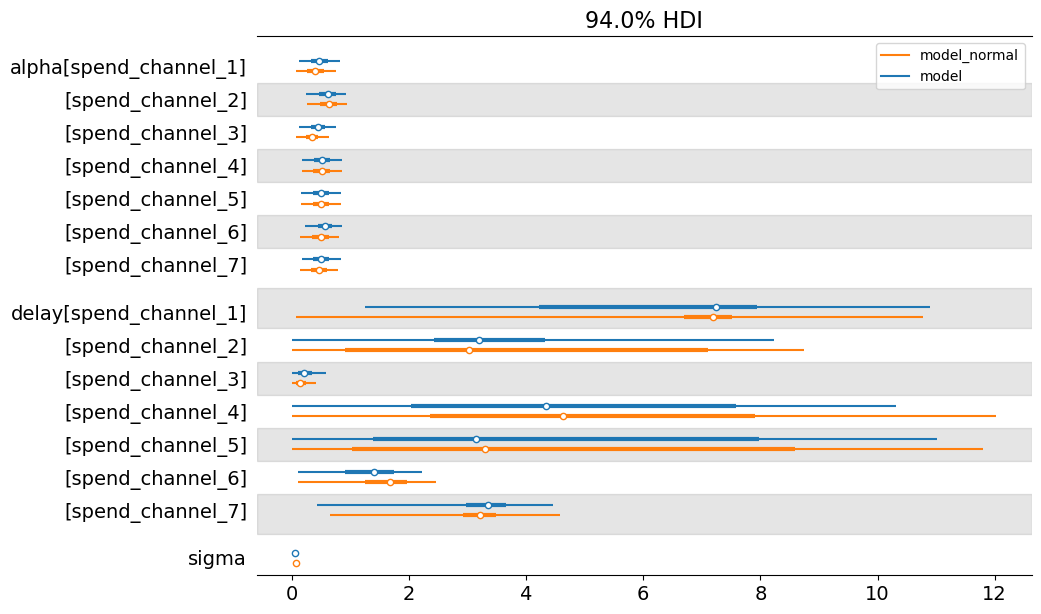

In [77]:
axes = az.plot_forest(
    data=[model_trace, model_trace_normal],
    model_names=["model", "model_normal"],
    var_names=['alpha','delay','sigma'],
    combined=True,
    figsize=(10, 7),
)
plt.show()

In [ ]:
axes = az.plot_forest(
    data=[model_trace, model_trace_normal],
    model_names=["model", "model_normal"],
    var_names=['alpha','delay','sigma'],
    combined=True,
    figsize=(10, 7),
)
plt.show()